In [75]:
# packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
cv2.__version__

'4.7.0'

In [76]:
# Display helper function
def display(img):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(new_img)
    # ax.imshow(img)

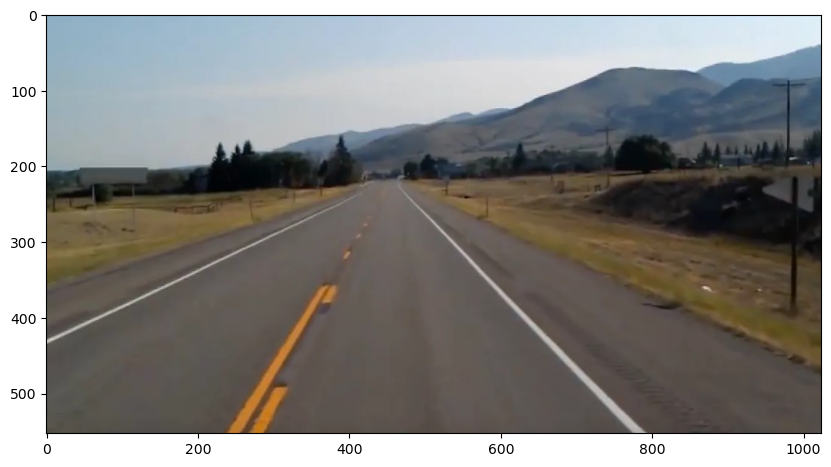

In [78]:
# Sample image
# Use proper paths for reading the images
lane_image = cv2.imread('road.jpg')
lane_image_2 = cv2.imread('road.jpg')
display(lane_image)

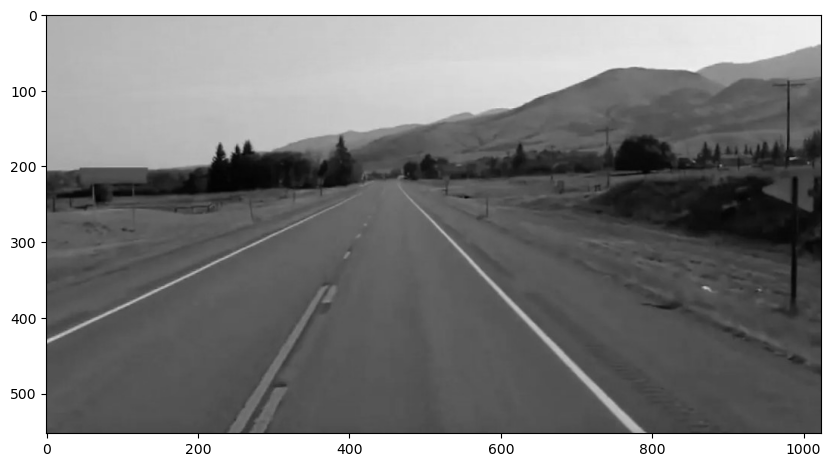

In [79]:
# grayscaled
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)
display(gray)

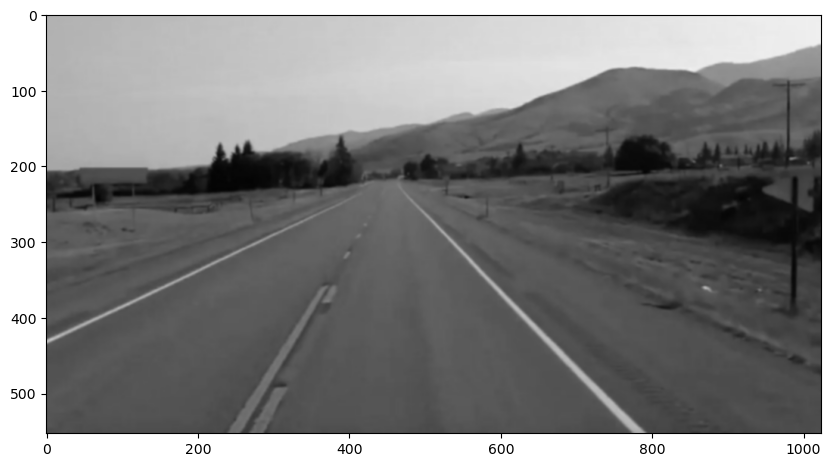

In [80]:
# blurred to reduces number of edges
blur = cv2.GaussianBlur(gray, (5,5), 1)
display(blur)

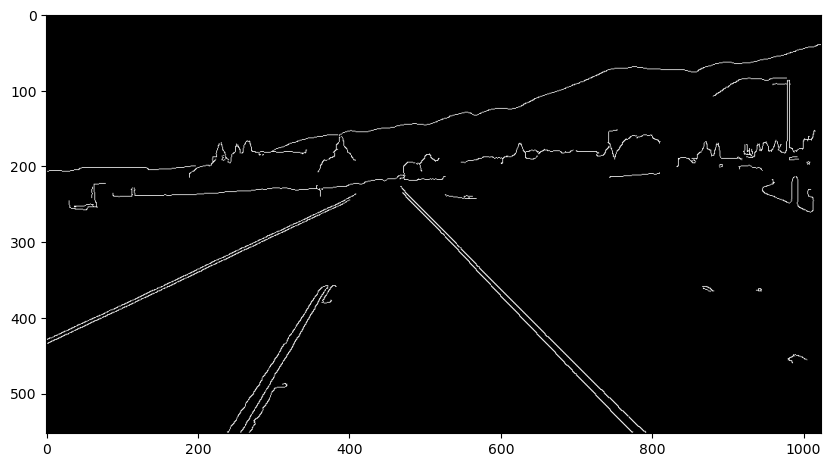

In [81]:
# edge detection
cannyImage = cv2.Canny(blur, 50, 150)
display(cannyImage)

In [82]:
# everything together as a function
def CannyEdge(image):
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    cannyImage = cv2.Canny(blur, 50, 150)
    return cannyImage                  

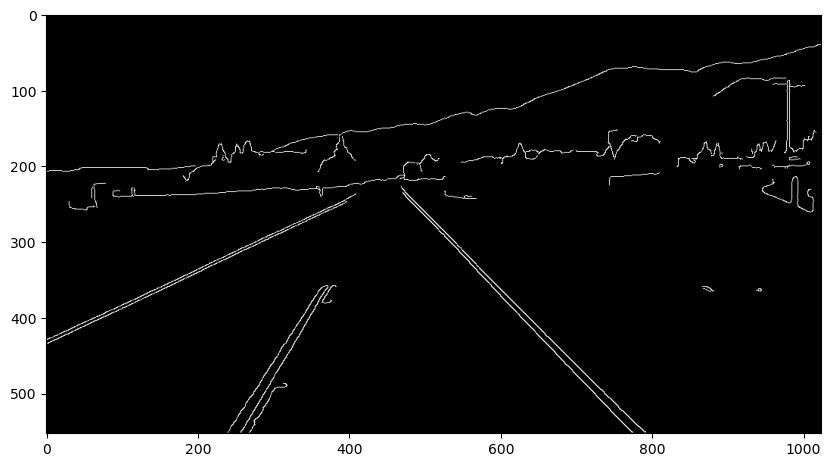

In [83]:
result=CannyEdge(lane_image)
display(result)

In [84]:
# region of interest in which it detects the lanes
def region_of_interest(image):
  height = image.shape[0]
  triangle = np.array([[(200, height),(550, 250),(1100, height),]], np.int32)
  mask = np.zeros_like(image)
  cv2.fillPoly(mask, triangle, (255,0,0))
  return mask

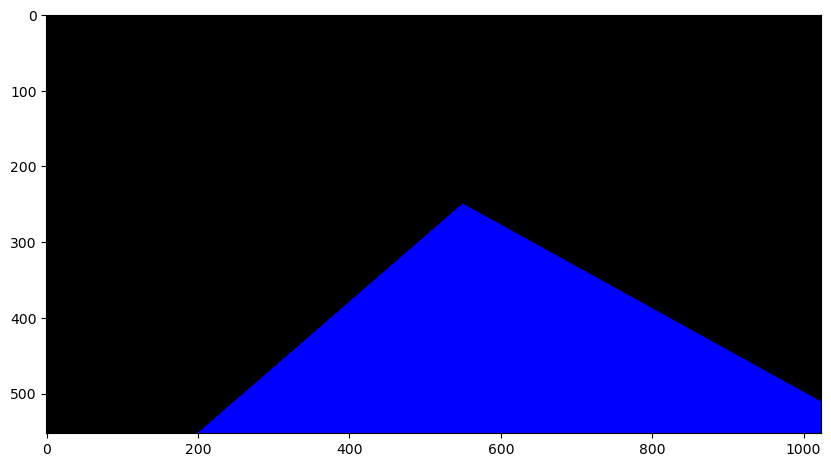

In [85]:
roi=region_of_interest(lane_image)
display(roi)

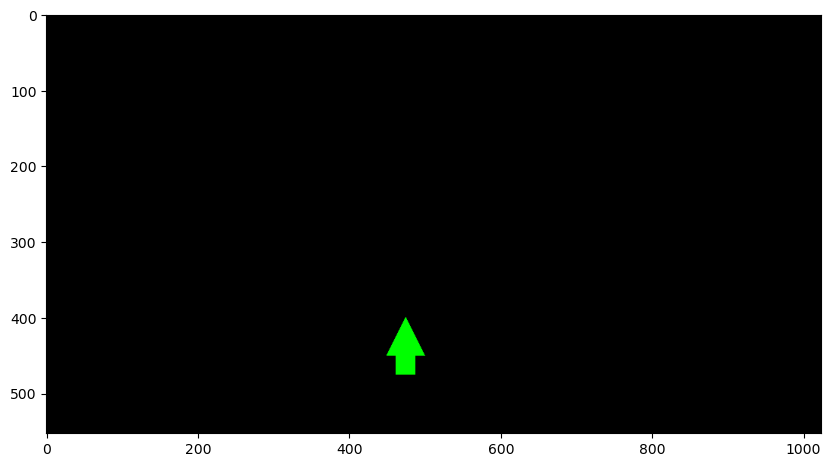

In [86]:
# Arrow function which points in which direction we are heading
def arrow(image):
    mask = np.zeros_like(image)
    height = image.shape[0]
    vertices = np.array([[(450, 450),(475, 400),(500, 450),]], np.int32)
    pts = vertices.reshape((-1,1,2))
    cv2.fillPoly(mask,[pts],color=(0,255,0))
    
    vertices2 = np.array([[(462.5, 450),(487.5, 450),(487.5, 475),(462.5,475),]], np.int32)
    pts2 = vertices2.reshape((-1,1,2))
    cv2.fillPoly(mask,[pts2],color=(0,255,0))
    
    return mask
result_0=(arrow(lane_image_2))
display(result_0)    

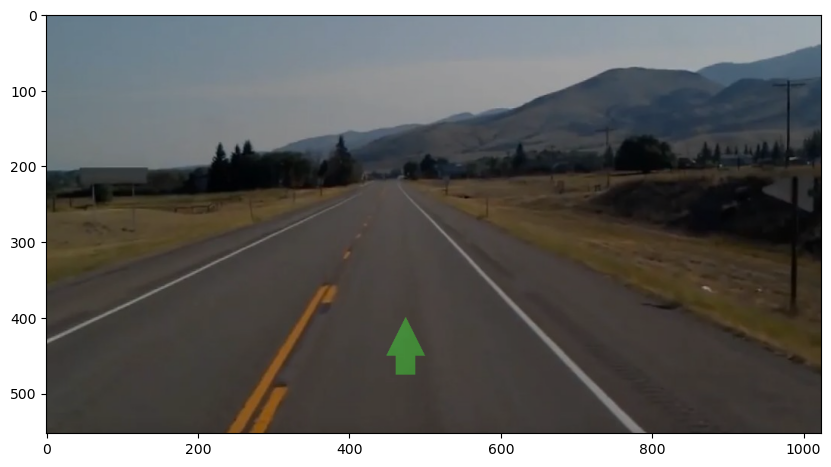

In [87]:
# blending it with sample image
blended = cv2.addWeighted(src1=lane_image_2,alpha=0.7,src2=result_0,beta=0.3,gamma=0)
display(blended)

In [88]:
# Using bitwise AND to get the lanes from the Triangle's R.O.I.
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([[(150, height),(550, 250),(1000, height),]], np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, triangle, (255,255,255))
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

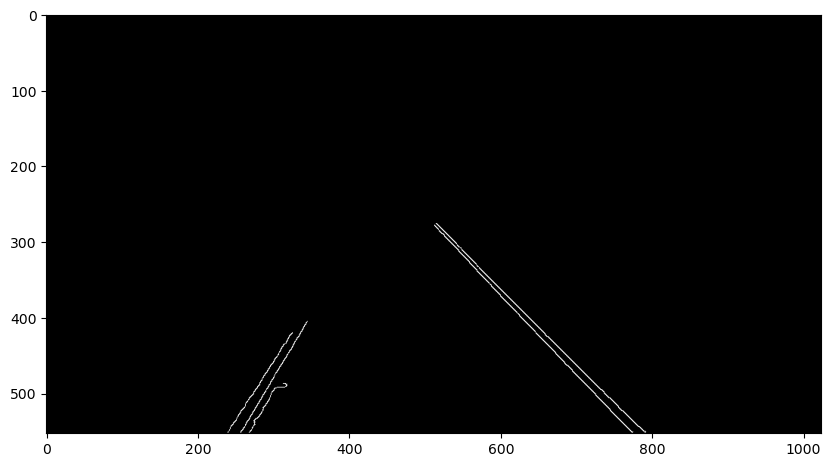

In [89]:
roi=region_of_interest(result)
display(roi)

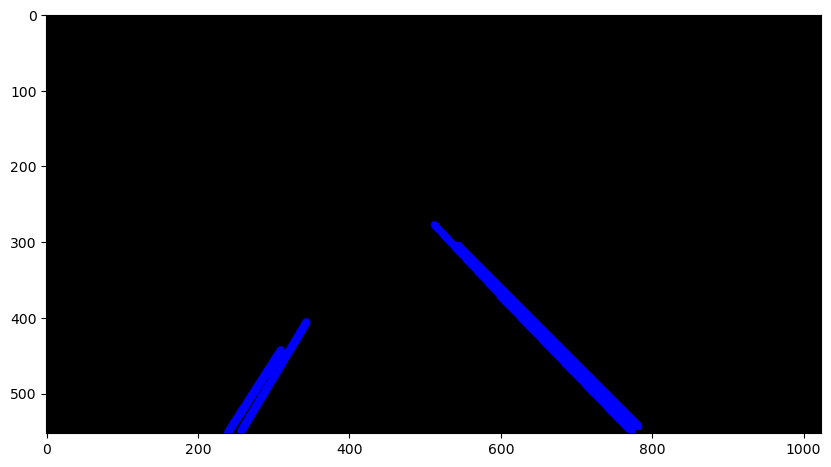

In [90]:
# Highlight the lines received from the previous function
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image
cropped_Image = region_of_interest(result)
rho = 2
theta = np.pi/180
threshold = 100
lines = cv2.HoughLinesP(cropped_Image,rho, theta, threshold, np.array ([]), minLineLength=40, maxLineGap=5)
line_image = display_lines(lane_image, lines)


display(line_image)

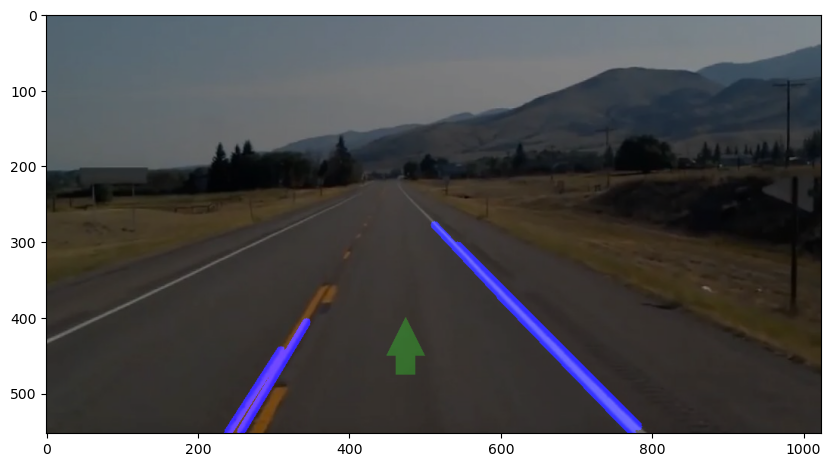

In [91]:
# Combine Arrow and line function
combo_image = cv2.addWeighted(blended, 0.8, line_image, 1, 1)
display(combo_image)

In [92]:
# Call all functions for the video
## use proper paths for video
## to use live internal cam use (0) and for external cam use (1)
cap = cv2.VideoCapture("test_video.mp4")
while(cap.isOpened()):
    _, frame = cap.read()
    
    frame=cv2.resize(frame,(1000,550))
    canny = CannyEdge(frame)
    cropped_Image = region_of_interest(canny)
    rho = 2
    theta = np.pi/180
    threshold = 100
    lines = cv2.HoughLinesP(cropped_Image,rho, theta, threshold, np.array ([ ]), minLineLength=40, maxLineGap=5)
    line_image = display_lines(frame, lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    
    # For arrow
    nav=(arrow(frame))
    blended = cv2.addWeighted(src1=combo_image,alpha=0.7,src2=nav,beta=0.3,gamma=0)
    cv2.imshow("Image", blended)
    
    # Without arrow
    # cv2.imshow("Image", combo_image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [94]:
# to make detected lines smooth
def make_points(image, line_parameters):
    slope, intercept = line_parameters
    y1 = int(image.shape[0])
    y2 = int(y1*3/5)
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    if lines is None:
        return None
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = make_points(image, left_fit_average)
    right_line = make_points(image, right_fit_average)
    return np.array((left_line, right_line))

In [95]:
# Call all functions for the video
cap = cv2.VideoCapture("test_video.mp4")
while(cap.isOpened()):
    _, frame = cap.read()
    
    frame=cv2.resize(frame,(1000,550))
    canny = CannyEdge(frame)
    cropped_Image = region_of_interest(canny)
    rho = 2
    theta = np.pi/180
    threshold = 100
    lines = cv2.HoughLinesP(cropped_Image,rho, theta, threshold, np.array ([ ]), minLineLength=40, maxLineGap=5)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    
    # For arrow
    nav=(arrow(frame))
    blended = cv2.addWeighted(src1=combo_image,alpha=0.7,src2=nav,beta=0.3,gamma=0)
    cv2.imshow("Image", blended)
    
    # Without arrow
    # cv2.imshow("Image", combo_image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Putting everything together as a python script
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def make_points(image, line_parameters):
    slope, intercept = line_parameters
    y1 = int(image.shape[0])
    y2 = int(y1*3/5)
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    if lines is None:
        return None
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = make_points(image, left_fit_average)
    right_line = make_points(image, right_fit_average)
    return np.array((left_line, right_line))


def CannyEdge(image):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, (5,5), 0)
  cannyImage = cv2.Canny(blur, 50, 150)
  return cannyImage

def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([[(200, height),(550, 250),(1100, height),]], np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image


# Arrow function which points in which direction we are heading
def arrow(image):
    mask = np.zeros_like(image)
    height = image.shape[0]
    vertices = np.array([[(450, 450),(475, 400),(500, 450),]], np.int32)
    pts = vertices.reshape((-1,1,2))
    cv2.fillPoly(mask,[pts],color=(0,255,0))
    
    vertices2 = np.array([[(462.5, 450),(487.5, 450),(487.5, 475),(462.5,475),]], np.int32)
    pts2 = vertices2.reshape((-1,1,2))
    cv2.fillPoly(mask,[pts2],color=(0,255,0))
    
    return mask


# Call all functions for the video
cap = cv2.VideoCapture("test_video.mp4")
while(cap.isOpened()):
    _, frame = cap.read()
    
    frame=cv2.resize(frame,(1000,550))
    canny = CannyEdge(frame)
    cropped_Image = region_of_interest(canny)
    rho = 2
    theta = np.pi/180
    threshold = 100
    lines = cv2.HoughLinesP(cropped_Image,rho, theta, threshold, np.array ([ ]), minLineLength=40, maxLineGap=5)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    
    # For arrow
    nav=(arrow(frame))
    blended = cv2.addWeighted(src1=combo_image,alpha=0.7,src2=nav,beta=0.3,gamma=0)
    # cv2.imshow("Image", blended)
    
    # Without arrow
    cv2.imshow("Image", combo_image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()